In [2]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

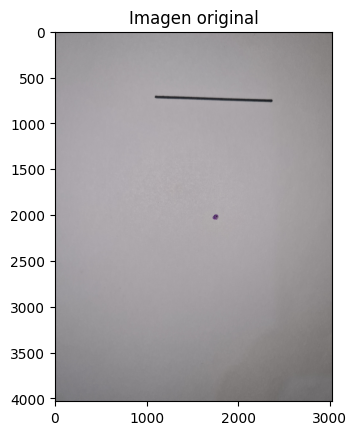

In [2]:
# Cargar la imagen desde el archivo
imagen = cv2.imread('.\images\img1.jpg')

plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.show()

## Paso 1: Deteccion de linea y enderezar la imagen

En este primer paso buscamos conseguir una imagen enderezada segun la referencia que es una linea recta. 


Para detectar bordes se utiliza una funcion llamada Canny. Esta funcion permite mediante un procesamiento en la imagen obtener aquellos puntos donde tenemos variaciones bruscas de color.
La idea es pasar de una imagen con un rango de colores variado a una imagen binaria donde unicamente se muestren los puntos de interes (bordes).

- Threshold1: nivel para detectar un borde debil.
- Threshold2: nivel para detectar un borde fuerte.
- ApertureSize: tamaño de matriz sobel. 



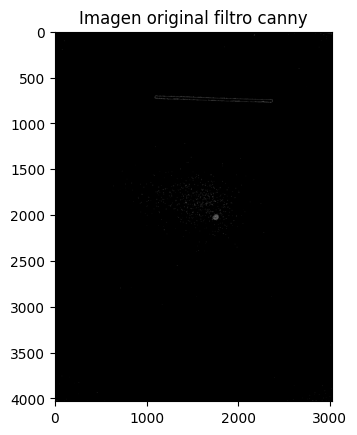

In [3]:
copia_imagen = imagen.copy()

bordes = cv2.Canny(copia_imagen,  threshold1=80,  threshold2=150, apertureSize=3) 

plt.imshow(cv2.cvtColor(bordes, cv2.COLOR_BGR2RGB))
plt.title("Imagen original filtro canny")
plt.show()


Para detectar lineas una vez hecho un plano binario, se utiliza la funcion HoughLines. Esta funcion se basa en un algoritmo que permite detectar lineas en una imagen y extraer sus coordenadas polares. 

- rho: Resolución en píxeles de la distancia ρ (la precisión de la distancia perpendicular).
- theta: Resolución angular en radianes de θ (por ejemplo, np.pi/180 para una resolución de 1 grado).
- threshold: Número mínimo de intersecciones en el espacio de parámetros para que se considere que una línea está presente. Cuanto mayor sea este valor, más "fuertes" deben ser las líneas detectadas.

Las lineas estan en coordenadas polares  
Es decir:   
ρ=x⋅cos(θ)+y⋅sin(θ)  

En donde:  
ρ (rho) es la distancia perpendicular desde el origen (0,0) hasta la línea.
θ (theta) es el ángulo que forma esa línea con el eje horizontal.

La coordenadas obtenidas son entonces el valor de la normal de la recta evaluada desde el origen y se pueden transformar en coordenadas cartesianas para obtener la ecuacion de una recta.

Para mas info [Documentacion](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)

In [4]:

lineas = cv2.HoughLines(bordes, rho= 1,theta= np.pi / 180,threshold= 200)

print(lineas)


[[[669.          1.6057029]]

 [[697.          1.6057029]]]


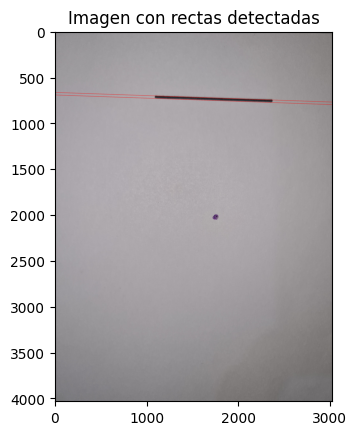

In [5]:
# Ejecutar para observar las rectas en la imagen
imagen_rectas = imagen.copy()

for line in lineas:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * (-b))
    y1 = int(y0 + 10000 * (a))
    x2 = int(x0 - 10000 * (-b))
    y2 = int(y0 - 10000 * (a))
    cv2.line(imagen_rectas, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(imagen_rectas, cv2.COLOR_BGR2RGB))
plt.title("Imagen con rectas detectadas")
plt.show()

Las lineas detectadas deben ser unicas y deben ser 2 ya que es nuestra referencia. Promediando su angulo podemos enderezar la imagen para que ahora esten completamente rectas.


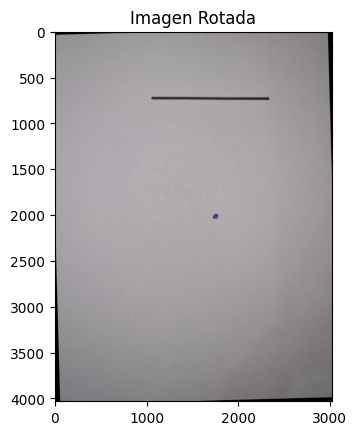

In [6]:
imagen_rotada = imagen.copy()

if len(lineas) != 2:
    print("Error en la deteccion de la referencia. Intente denuevo")
else:
    angulo = (lineas[0][0][1] + lineas[1][0][1]) / 2
    angulo_rotacion = np.degrees(angulo) - 90
    alto, ancho, _ = imagen_rotada.shape
    centro = (ancho // 2, alto // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    imagen_rotada = cv2.warpAffine(imagen_rotada, matriz_rotacion, (ancho, alto), flags=cv2.INTER_CUBIC)
   
    plt.imshow(cv2.cvtColor(imagen_rotada, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Rotada")
    plt.show()


## Paso 2: Medir referencia y definir unidad de pixel

En este paso se busca medir la referencia y obtener de ella la cantidad de pixeles que la conforman. Una vez obtenido esto, debido a que su distancia es conocida se podran obtener valores de mediciones de otros objetos en la imagen.




In [7]:
copia_imagen = imagen_rotada.copy()
bordes = cv2.Canny(copia_imagen,  threshold1=50,  threshold2=100, apertureSize=3) 

lineas = cv2.HoughLinesP(bordes, rho=1, theta=np.pi/180, threshold=200, minLineLength=800, maxLineGap=100)

# Promedio y obtengo la mediana de las lineas detectadas
largo_t = np.array([np.sqrt((x2 - x1)**2 + (y2 - y1)**2) for linea in lineas for x1, y1, x2, y2 in linea]) if lineas is not None else None

px_linea = np.median(largo_t)

referencia = 5 # CM

dist_px = referencia / px_linea

print(dist_px)

0.003952569169960474


## Paso 3: Detectar en una imagen una linea y utilizar esa medicion para medir otra linea de la misma imagen.

En este paso lo que se propone es en una imagen filtrar una linea de referencia, realizar todo el procedimiento mencionado previamente y obtener la medicion de un pixel. Una vez obtenida la referencia obtener la otra linea y medir su tamaño.

(2026, 2701, 3)


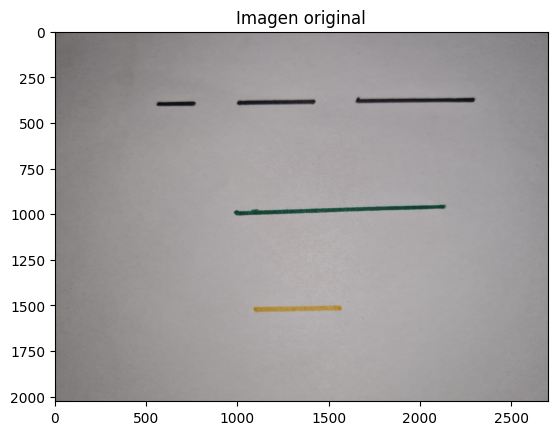

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar la imagen desde el archivo
imagen_3 = cv2.imread('.\images\img3.png')

print(imagen_3.shape)

plt.imshow(cv2.cvtColor(imagen_3, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.show()


Ahora se procede a diferenciar la linea de referencia (color verde) de esta forma poder identificar la unidad de pixel y poder enderezar la imagen.

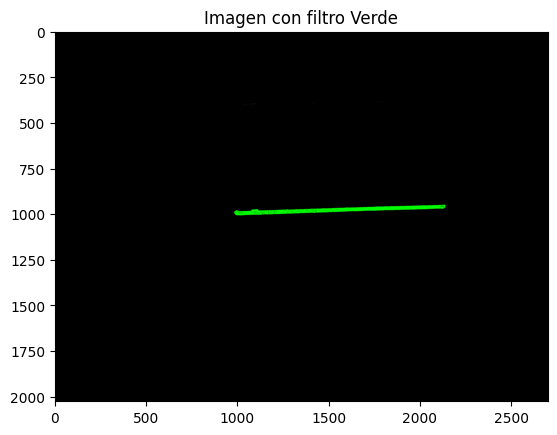

In [9]:
imagen_3_proc = imagen_3.copy()

# Matriz para convertir en color blanco la linea de interes

imagen_or = np.ones(shape=imagen_3_proc.shape,dtype= np.uint8) * 255
imagen_and = np.zeros(shape=imagen_3_proc.shape,dtype= np.uint8)
imagen_and[:,:,1] = 255

# Verde (Referencia)
imagen_3_proc = cv2.cvtColor(imagen_3_proc, cv2.COLOR_BGR2HSV)
limite_superior= np.array([130, 255,255]) # [130, 255,255] # Detecto verde 
limite_inferior = np.array([60, 55, 55])  # [60, 55, 55]

mascara= cv2.inRange(imagen_3_proc, limite_inferior, limite_superior)

imagen_verde = cv2.bitwise_or(imagen_3_proc, imagen_or, mask=mascara)
imagen_verde = cv2.bitwise_and(imagen_verde, imagen_and, mask=mascara)

plt.imshow(cv2.cvtColor(imagen_verde, cv2.COLOR_BGR2RGB))
plt.title("Imagen con filtro Verde")
plt.show()

Una vez detectada la linea de referencia habiendo aplicado los filtros correspondientes, es que podemos utilizarla para obtener todos los parametros necesarios para otras mediciones.


Las lineas detectadas son:
[[[ 999 1009 1862  979]]

 [[ 982  988 1872  957]]]

El valor de distancia que representa un pixel es: 0.005701055995549536cm


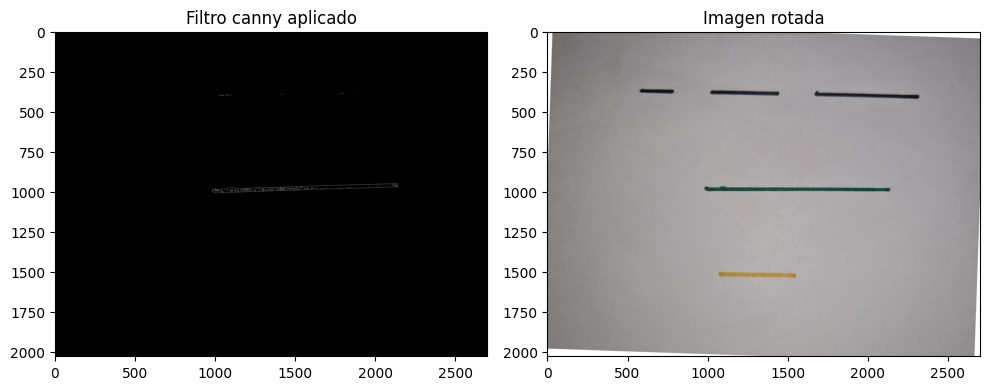

In [10]:
img_rotate = imagen_3.copy()

# aplico filtro de bordes
res = cv2.Canny(imagen_verde,  threshold1=50,  threshold2=60, apertureSize=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Filtro canny aplicado")
ax1.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

# Detecto lineas
lineas = cv2.HoughLinesP(res, rho=1, theta=np.pi/180, threshold=200, minLineLength=800, maxLineGap=100)

print("Las lineas detectadas son:")
print(lineas)

if len(lineas) == 0:
    print("Error en la deteccion de la referencia. Intente denuevo")
else:
    # Promedio y obtengo la mediana de las lineas detectadas
    angulos = np.array([np.degrees(np.arctan((y2 - y1)/(x2 - x1))) for linea in lineas for x1, y1, x2, y2 in linea]) 

    # Promedio y obtengo la mediana de las lineas detectadas
    largos = np.array([np.sqrt((x2 - x1)**2 + (y2 - y1)**2) for linea in lineas for x1, y1, x2, y2 in linea]) 
    
    angulo_rotacion = angulos.mean()
    alto, ancho, _ = img_rotate.shape
    centro = (ancho // 2, alto // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo_rotacion, 1.0)
    imagen_rotada = cv2.warpAffine(img_rotate, matriz_rotacion, (ancho, alto), flags=cv2.INTER_CUBIC,borderValue=(255, 255, 255))
    ax2.imshow(cv2.cvtColor(imagen_rotada, cv2.COLOR_BGR2RGB))
    ax2.set_title("Imagen rotada")
    plt.tight_layout()
    plt.plot()
    # Calculo medicion de un pixel
    referencia = 5 # CM

    dist_px = referencia / largos.mean()

    print(f"\nEl valor de distancia que representa un pixel es: {dist_px}cm")




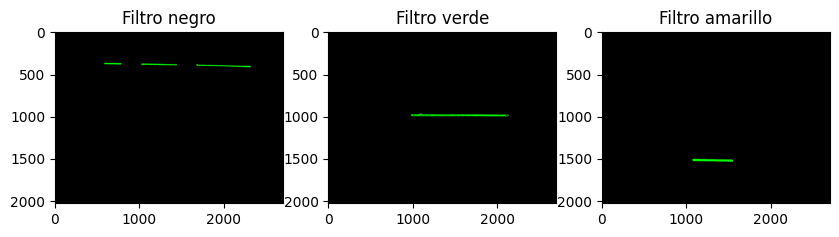

In [11]:
imagen_3_proc = imagen_rotada.copy()

### Aplico un filtro por colores

# Verde (Referencia)
imagen_3_proc = cv2.cvtColor(imagen_3_proc, cv2.COLOR_BGR2HSV)
limite_superior= np.array([130, 255,255]) # [130, 255,255] # Detecto verde 
limite_inferior = np.array([55, 55, 60])  # [60, 55, 55]

mascara= cv2.inRange(imagen_3_proc, limite_inferior, limite_superior)
imagen_verde = cv2.bitwise_or(imagen_3_proc, imagen_or, mask=mascara)
imagen_verde = cv2.bitwise_and(imagen_verde, imagen_and, mask=mascara)

# Negro (Objetos a medir)
limite_superior= np.array([200, 200,45]) # Detecto Negro 
limite_inferior = np.array([0, 0, 0])  # 

mascara= cv2.inRange(imagen_3_proc, limite_inferior, limite_superior)
imagen_negra = cv2.bitwise_or(imagen_3_proc, imagen_or, mask=mascara)
imagen_negra = cv2.bitwise_and(imagen_negra, imagen_and, mask=mascara)

# Amarillo (otro)
limite_superior= np.array([60, 255, 255]) # Detecto amarillo 
limite_inferior = np.array([5, 80, 80])  #

mascara= cv2.inRange(imagen_3_proc, limite_inferior, limite_superior)
imagen_amarillo = cv2.bitwise_or(imagen_3_proc, imagen_or, mask=mascara)
imagen_amarillo = cv2.bitwise_and(imagen_amarillo, imagen_and, mask=mascara)

## Ploteo resultados

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

ax1.set_title("Filtro negro")
ax1.imshow(cv2.cvtColor(imagen_negra, cv2.COLOR_BGR2RGB))
ax2.set_title("Filtro verde")
ax2.imshow(cv2.cvtColor(imagen_verde, cv2.COLOR_BGR2RGB))
ax3.set_title("Filtro amarillo")
ax3.imshow(cv2.cvtColor(imagen_amarillo, cv2.COLOR_BGR2RGB))


Lineas medidas: [1.00353161 3.10810049 2.38337554 2.68674626 1.12333952 1.19186163
 1.67707975 2.84579219 2.34382747 0.75288483 0.94110604]


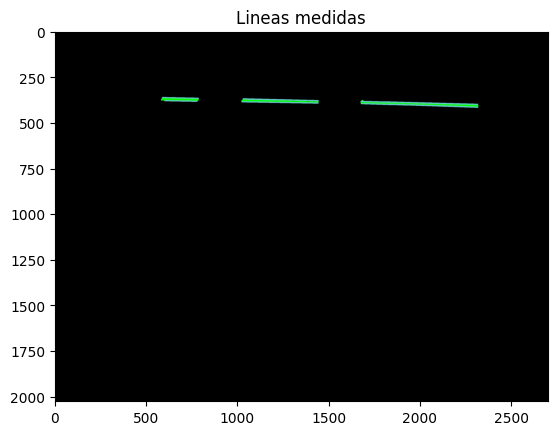

In [12]:
## mido distancia de lineas negras
# Convertir a escala de grises
medicion = imagen_negra.copy()

res = cv2.Canny(medicion,  threshold1=100,  threshold2=200, apertureSize=3,L2gradient = True)

# Detecto lineas
lineas = cv2.HoughLinesP(res, rho=1, theta=np.pi/360, threshold=100, minLineLength=100, maxLineGap=30)

#print(lineas)
if lineas is not None:
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        cv2.line(medicion, (x1, y1), (x2, y2), (200, 200, 100), 5)

largos = np.array([np.sqrt((x2 - x1)**2 + (y2 - y1)**2) for linea in lineas for x1, y1, x2, y2 in linea]) 


print(f"Lineas medidas: {largos*dist_px}")
plt.title("Lineas medidas")
plt.imshow(cv2.cvtColor(medicion, cv2.COLOR_BGR2RGB))
plt.show()



Con este metodo vemos que si bien se puede obtener mediciones de las lineas (dentro de los resultados obtenidos estan las mediciones exactas de 1, 2 y 3cm), estas no son precisas ya que se pueden cortar, ademas de que si no estan perfectamente alineadas el algortimo no las detecta en forma correcta.
Se detectan muchas mas lineas de las reales y hacer una discriminacion entre cuales son las correctas resulta complicado. 
Se propone otro metodo para poder detectar presencia de objetos y medir su distancia.

# Metodo 2

En este metodo se plantea detectar una referencia compuesta por lineas de un determinado color. De pruebas previas se observo que mientras esta referencia sea con una orientacion perfectamente paralela con la imagen, la deteccion de lineas es bastante positiva. 
Como referencia se propone una serie de lineas de un mismo color todas paralelas entre si de la misma distancia, permitiendo asi detectar cada una de ellas y promediarlas para obtener una referencia precisa.
Una vez obtenida la referencia precisa y conociendo esta distancia se propone formar un esquema de rejilla en donde cada posicion de esta tenga una distancia impuesta de ante mano. Lo que se hara entonces es seccionar la imagen a analizar con dicha rejilla haciendo coincidir la referencia con la cantidad de cuadrados de rejilla que equivalentes.
Luego se promediaran dentro de cada porcion de rejilla los valores de los pixeles y en caso de que superen un valor umbral se detectara como un objeto. Si la rejilla es lo suficientemente chica en comparacion con la imagen entonces la medicion que se hara para distancias sera razonamblemente buena. 

Rejilla grande

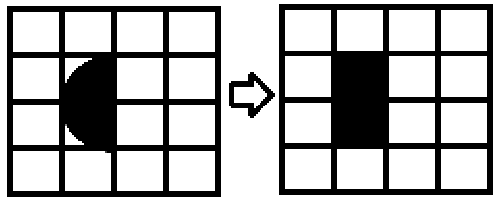

Rejilla pequeña

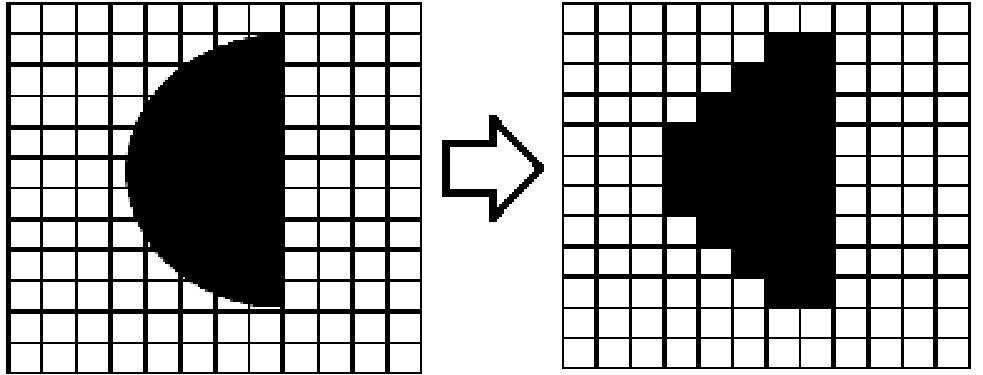

En este caso los datos que se obtendran no son mediciones de distancia sino que se obtendra como resultado la rejilla completa. Esto permitira luego hacer una rejilla identica con el sensor de distancia y utilizar ambos para poder entrenar al modelo de la red neuronal.

La cuadricula que se plantea inicialmente busca cumplir las siguiente condiciones:
* Se propone que la misma tenga un area de 20cm x 20cm.
* Se plantea tener una resolucion de 0.1cm. 

En consecuencia la cuadricula sera de 200x200.

Es importante fijate un punto de referencia por lo que se agrega ademas un punto de color distinto que sirva de punto central de la imagen.
Este punto se ubicara en las coordenadas (x=100 ; y=0)

Referencia de colores:
- Verde: Marca referencia.
- Negro: Lineas a detectar.
- Amarillo: Punto central referencia.


In [13]:
# imports
#%reset -f

import cv2
import numpy as np
import matplotlib.pyplot as plt

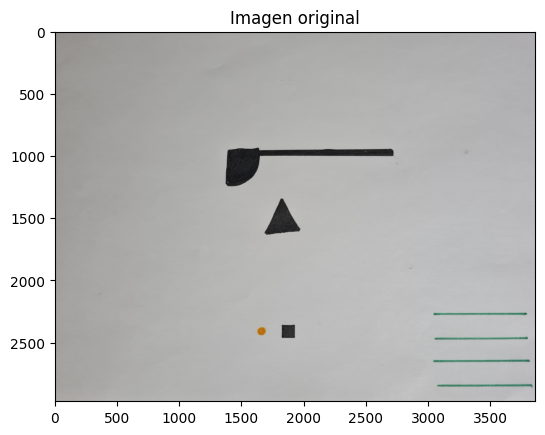

In [14]:
# Cargar la imagen desde el archivo
imagen = cv2.imread('.\images\img4.jpg')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.imshow(imagen)
plt.title("Imagen original")
plt.show()

In [25]:
#Detecto referencia, enderezo imagen y obtengo unidad de pixel.
def filtro_color(img, color_filtro):
    # Color_filtro = verde, amarillo, negro
    _img = img.copy()
    _img = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV)

    if color_filtro == "negro":
        limite_superior= np.array([200, 130,100]) # [200, 130,100] # Detecto Negro 
        limite_inferior = np.array([0, 0, 0])     # [0, 0, 0]
    # Aplico filtro de color
    elif color_filtro == "amarillo":
        limite_superior= np.array([60, 250, 255]) # [60, 255, 255]Detecto amarillo 
        limite_inferior = np.array([5, 120, 190])   # [5, 80, 80]
    elif color_filtro == "verde":
        limite_superior= np.array([90, 250,200]) # [100, 250,200]# Detecto verde 
        limite_inferior = np.array([60, 55, 30])  # [55, 55, 10]
    else:
        return 
    
    # Establezco color rojo a los objetos filtros obtenidos
    _or = np.ones(shape=_img.shape,dtype= np.uint8) * 255
    _and = np.zeros(shape=_img.shape,dtype= np.uint8)
    _and[:,:,:] = 255
    
    
    #Realizo mascara de color
    _mascara= cv2.inRange(_img, limite_inferior, limite_superior)
    _img = cv2.cvtColor(_img, cv2.COLOR_HSV2RGB)
    _detectado = cv2.bitwise_or(_img, _or, mask=_mascara)
    _detectado = cv2.bitwise_and(_detectado, _and, mask=_mascara)
    _detectado = cv2.bitwise_not(_detectado)
    return _detectado

def detectar_referencia_px(img, color_ref = "verde",ref = 5):
    # Color_ref = verde, amarillo, negro
    # ref = largo de linea en cm

    _img = img.copy()
    _img2 = filtro_color(_img, "verde")
   
    _res = cv2.Canny(_img2,  threshold1=50,  threshold2=60, apertureSize=3)
    # Detecto lineas
    plt.imshow(_res)
    _lineas = cv2.HoughLinesP(_res, rho=1, theta=np.pi/360, threshold=200, minLineLength=180, maxLineGap=30)
    
    if len(_lineas) == 0:
        print("Error en la deteccion de la referencia. Intente denuevo")
    else:
        # Promedio y obtengo la mediana de las lineas detectadas
        angulos = np.array([np.degrees(np.arctan((y2 - y1)/(x2 - x1))) for linea in _lineas for x1, y1, x2, y2 in linea]) 

        angulo_rotacion = angulos.mean()
        alto, ancho, _ = _img.shape
        centro = (ancho // 2, alto // 2)
        matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo_rotacion, 1.0)
        imagen_rotada = cv2.warpAffine(_img, matriz_rotacion, (ancho, alto), flags=cv2.INTER_CUBIC,borderValue=(255, 255, 255))
        
    _res = filtro_color(imagen_rotada, "verde")
   
    _res = cv2.Canny(_res,  threshold1=10,  threshold2=30, apertureSize=3)

    # Detecto lineas
    _lineas = cv2.HoughLinesP(_res, rho=0.5, theta=np.pi/180, threshold=100, minLineLength=200, maxLineGap=100)

    x1 =  np.min(_lineas[:, 0, 0])  # Columna de X1
    x2 = np.max(_lineas[:, 0, 2])  # Columna de X2

    largos = np.array([np.sqrt((x2 - x1)**2 + (y2 - y1)**2) for linea in _lineas for _, y1, _, y2 in linea]) 
    
    # Calculo medicion de un pixel

    unidad_px = ref / largos.mean()

    return unidad_px,imagen_rotada

In [16]:
px_dim, img_rot = detectar_referencia_px(imagen,"verde",5)
print(f"El pixel mide {px_dim}cm")

El pixel mide 0.006729475100942127cm


In [18]:
# Busco centro de referencia
def buscar_centro(imagen):
    filtro_amarillo =  filtro_color(imagen,"amarillo")
    #plt.imshow(filtro_amarillo)
    coordenadas_negra = np.argwhere(cv2.bitwise_not(filtro_amarillo))
    promedio = np.round(coordenadas_negra.mean(axis=0))
    return promedio[0:2][::-1]


In [18]:
centro = buscar_centro(img_rot)
print(f"Referencia detectada en {centro}")

Referencia detectada en [1658. 2410.]


In [19]:
def trasladar_imagen_referencia(imagen, coord_ref, coord_dest, dim_out=0):
    # Cargar la imagen original
    _imagen = imagen.copy()
    
    # Obtener las dimensiones de la imagen
   
    alto, ancho = _imagen.shape[:2]
        
    _desp_x =   coord_dest[0] - coord_ref[0]
    _desp_y =   coord_dest[1]  - coord_ref[1]
    
    # Crear una matriz de transformación (traslación)
    M = np.float32([[1, 0, _desp_x], [0, 1, _desp_y]])
    
    # Aplicar la transformación de traslación
    imagen_trasladada = cv2.warpAffine(imagen, M, (ancho, alto), borderValue=(255, 255, 255)) # Rellena con blanco
    if dim_out > 0:
        imagen_trasladada =  imagen_trasladada[0:dim_out,0:dim_out]
    return imagen_trasladada

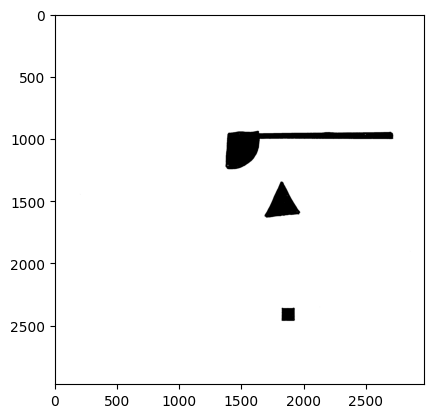

In [20]:

# Parametros rejilla:
dim_cuadrado=0.1 # Cm lado
dim_rejilla = 20 # Cm por lado


# Calculo la cantidad de pixeles para la cuadricula.
cant_cuadrados = int(dim_rejilla / dim_cuadrado)

cant_pxl_cuadrado = dim_cuadrado/ px_dim

cant_pxl_rejilla = int(cant_pxl_cuadrado * cant_cuadrados)

# Determino el punto donde quiero mover la referencia
centro = [cant_pxl_rejilla//2,cant_pxl_rejilla - int(cant_pxl_cuadrado*10)]

# Me quedo solo con las lineas negras que son las distancias que quiero medir.
_img = filtro_color(img_rot,"negro")
_img = trasladar_imagen_referencia(_img, centro,centro,cant_pxl_rejilla)
plt.imshow(_img)

In [20]:
def generar_cuadrilla(imagen, separacion_px, color=(255, 0, 0)):
    # Crear una imagen blanca del tamaño especificado
    _imagen = imagen.copy()
    ancho,alto = _img.shape[0:2]
    # Dibujar líneas horizontales y verticales con la separación deseada
    for x in range(0, ancho, separacion_px):
        cv2.line(_imagen, (x, 0), (x, alto), color, 2)  # Líneas verticales

    for y in range(0, alto, separacion_px):
        cv2.line(_imagen, (0, y), (ancho, y), color, 2)  # Líneas horizontales

    return _imagen


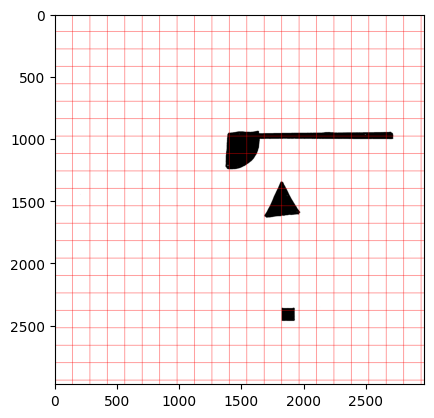

In [22]:
# Ejemplo de cuadrilla mas grande para mostrar la segmentacion.
plt.imshow(generar_cuadrilla(_img,int(cant_pxl_cuadrado)*10))

In [21]:
def resize_y_threshold(imagen, nuevo_ancho, nuevo_alto, threshold=127):
    # Hacer un resize de la imagen a 200x200 usando el método de INTER_AREA (adecuado para reducir)
    imagen_redimensionada = cv2.resize(imagen, (nuevo_ancho, nuevo_alto), interpolation=cv2.INTER_AREA)
    imagen_redimensionada = cv2.bitwise_not(imagen_redimensionada)
    # Aplicar el threshold: si el valor promedio del píxel supera el threshold, se pone negro (0)
    # Sino, se pone blanco (255)
    _, imagen_binarizada = cv2.threshold(imagen_redimensionada, threshold, 255, cv2.THRESH_BINARY_INV)
    
    return imagen_binarizada

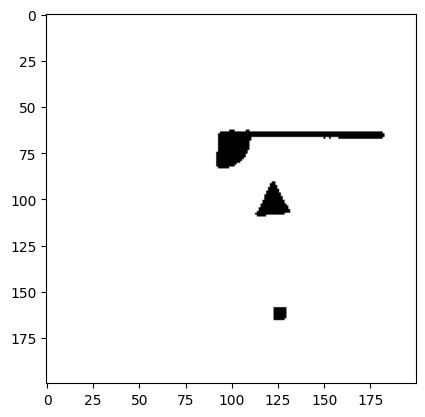

In [24]:
plt.imshow(resize_y_threshold(_img,200,200))

Podemos entonces resumir todo el proceso, desde que se toma una imagen hasta que se obtiene la matriz de 200x200 con la siguiente funcion


In [22]:
def crop_img(img,centro, pxl_dim):
    
    dim = [pxl_dim[0],pxl_dim[1],3]

    _ret = np.ones(dim,dtype=np.uint8)*255

    pxl_x_inicial =  max(0, int(centro[0] - pxl_dim[0] // 2))
    pxl_x_final   =  min(img.shape[0], int(centro[0] + pxl_dim[0]//2))
    pxl_y_final   =  int(centro[1]) + 50
    pxl_y_inicial =  max(0,int(centro[1] - pxl_dim[1] + 50))
    
    _img_crop = img[pxl_y_inicial:pxl_y_final,pxl_x_inicial:pxl_x_final,:]

    x,y = _img_crop.shape[0:2]
    _ret[:x,:y,:] = _img_crop
 
    # Debug

    #print(f"pxl= {pxl_dim}; centro= {centro}, shape_IMG {img.shape[0:2]}")
    #print(f"Valor y: inicial= {pxl_y_inicial}; final= {pxl_y_final}")
    #print(f"Valor x: inicial= {pxl_x_inicial}; final= {pxl_x_final}")
    #print(f"Centro= {centro}")
    #print(f"Pxl recortados= {_img_crop.shape[0:2]}")
    #print(f"Tamaño img salida= {_ret.shape[0:2]} ")

    return _ret


In [23]:

def get_matriz(ruta_img):

    # Levanto la imagen y la proceso en RGB
    _img = cv2.imread(ruta_img)
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

    # Detecto la referencia y obtengo medida de px
    _px_dim, _img_rot = detectar_referencia_px(_img,"verde",ref=5) # Ref: medida en cm de la linea de referencia

    # Detecto referencia de centro
    _centro = buscar_centro(_img_rot)

    # Defino rejilla
    # Parametros rejilla:
    dim_cuadrado=0.1 # Cm lado
    dim_rejilla = 20 # Cm por lado

    # Calculo la cantidad de pixeles para la cuadricula.
    _cant_cuadrados = int(dim_rejilla / dim_cuadrado)

    _cant_pxl_cuadrado = dim_cuadrado/ _px_dim

    _cant_pxl_rejilla = int(_cant_pxl_cuadrado * _cant_cuadrados)

    # Recorto la imagen para que tenga el tamaño de pixeles deseado (Solo queda una superficie de (dim_rejilla X dim_rejilla) )
    _img = crop_img(_img_rot,_centro,[_cant_pxl_rejilla,_cant_pxl_rejilla])
    
    # Determino el punto donde quiero mover la referencia
    _new_centro = [_img.shape[0]//2, _img.shape[1]]
    # Busco el centro de la imagen
    _centro = buscar_centro(_img)
    
    # Me quedo solo con las lineas negras que son las distancias que quiero medir.
    _img = filtro_color(_img,"negro")
    
    # Traslado la imagen desde el punto de referencia al punto deseado en la imagen
    _img = trasladar_imagen_referencia(_img, _centro, _new_centro)

    # Promedio los cuadrados de la rejilla para que solo tengan un PXL (bajo resolucion)
    _resultado = resize_y_threshold(_img,200,200,threshold=50)

    return _resultado


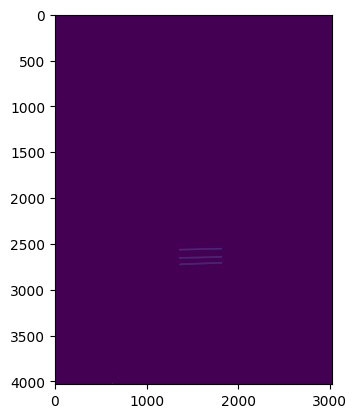

In [26]:

res = get_matriz(".\images\imgCheck2.jpg")
#plt.imshow(res)

# Prueba de algoritmo
A continuacion se hace una prueba con distintas imagenes tomadas en distintas distancias y angulos. Lo que se busca es ver que a pesar de variar la imagen, las referencia permiten mantener las coordenadas estables y distancias.

In [1]:
# Aseguro que cuando haya un cambio en la libreria se actualice

%load_ext autoreload
%autoreload 2

import measureLine as meas

In [ ]:
imagenes = [".\images\imgCheck1.jpg",
            ".\images\imgCheck2.jpg",
            ".\images\imgCheck3.jpg",
            ".\images\imgCheck4.jpg",
            ".\images\imgCheck5.jpg",
            ".\images\imgCheck6.jpg",]

matrices_resultados = []
print("Iniciando chequeo de imagenes....")
for this_img in imagenes:
    print(f"Procesando imagen: {this_img}")
    _img = cv2.imread(this_img)
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    matrices_resultados.append(_img)
print("Proceso terminado.")
print("Ploteo de imagenes")
fig, axes= plt.subplots(2, 3, figsize=(10, 4))
# print(axes.shape)
# print(type(axes))
axes = axes.flatten()
for indice,this_matrix in enumerate(matrices_resultados):
    axes[indice].set_title(f"Imagen: {indice} ")
    axes[indice].imshow(this_matrix)
plt.tight_layout()
plt.plot()

Iniciando chequeo de imagenes....
Procesando imagen: .\images\imgCheck1.jpg
Procesando imagen: .\images\imgCheck2.jpg
Procesando imagen: .\images\imgCheck3.jpg
Procesando imagen: .\images\imgCheck4.jpg
Procesando imagen: .\images\imgCheck5.jpg
Procesando imagen: .\images\imgCheck6.jpg
Proceso terminado.
Ploteo de imagenes


[]

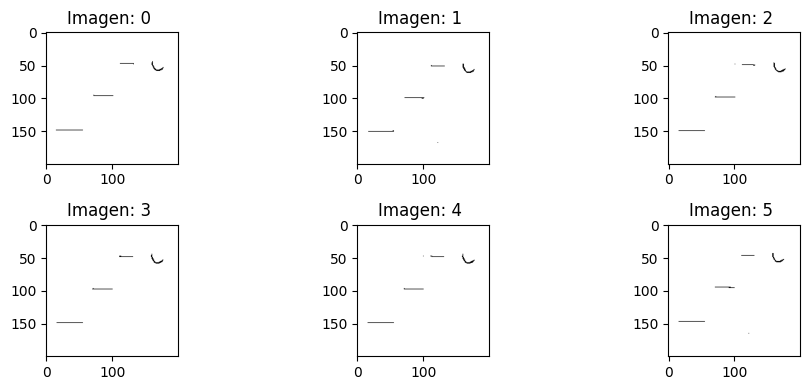

In [50]:
imagenes = [".\images\imgCheck1.jpg",
            ".\images\imgCheck2.jpg",
            ".\images\imgCheck3.jpg",
            ".\images\imgCheck4.jpg",
            ".\images\imgCheck5.jpg",
            ".\images\imgCheck6.jpg",
            ]
#".\images\imgCheck7.jpg",

matrices_resultados = []
print("Iniciando chequeo de imagenes....")
for this_img in imagenes:
    print(f"Procesando imagen: {this_img}")
    matrices_resultados.append(meas.get_matriz(this_img,0.1,20))
print("Proceso terminado.")
print("Ploteo de imagenes")
fig, axes= plt.subplots(2, 3, figsize=(10, 4))
# print(axes.shape)
# print(type(axes))
axes = axes.flatten()
for indice,this_matrix in enumerate(matrices_resultados):
    axes[indice].set_title(f"Imagen: {indice} ")
    axes[indice].imshow(this_matrix)
plt.tight_layout()
plt.plot()

In [34]:
from capture import IP_CAMERA 
import matplotlib.pyplot as plt
import time 

cam = IP_CAMERA("192.168.0.125",resolution=IP_CAMERA.SIZE1920x1080)
cam.init_camera()
cam.cmdSender(cam.toggleLED)
cam.cmdSender(cam.autoFocus)
time.sleep(1)
cam.set_rotation_angle(angle =270)
image = cam.get_img()
cv2.imwrite("./this_img.jpg",cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
cam.disconnect()
if image is not None:
    pass
    #plt.imshow(meas.get_matriz("./this_img.jpg",0.1,20))
    


Conectando a la cámara IP en http://192.168.0.125:4747/video?1920X1080


: 

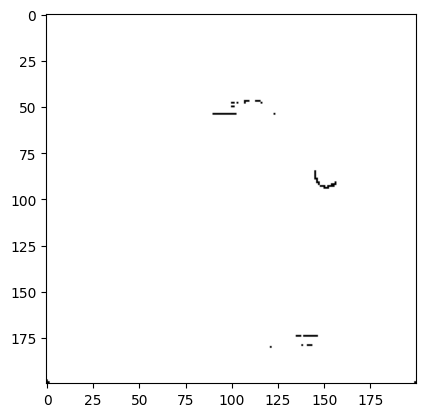

In [23]:
_img = meas.resize_y_threshold(_img,(200,200))
plt.imshow(meas.grey2rgb(_img))